## BERT

In [1]:
import re
import pandas as pd
import numpy as np
import tensorflow as tf
from transformers import TFBertModel, BertTokenizer
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report

# Load the dataset
df = pd.read_csv('PQEvents_Ticket_csv.csv')

# Data Preprocessing
df['Cause'] = df['Cause'].replace(['Unknown', 'Undetermined'], np.nan)
df = df.dropna(subset=['Cause'])
df = df[df['Details'].apply(lambda x: isinstance(x, str))]

def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    return text

df['Details'] = df['Details'].apply(clean_text)

print(f"Dataset shape: {df.shape}")

# Prepare labels
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df['Cause'])
y = tf.keras.utils.to_categorical(y)
X = df['Details'].tolist()

# Initialize tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

def create_model(num_classes):
    bert_model = TFBertModel.from_pretrained('bert-base-cased')
    input_ids = tf.keras.layers.Input(shape=(128,), dtype=tf.int32, name='input_ids')
    attention_mask = tf.keras.layers.Input(shape=(128,), dtype=tf.int32, name='attention_mask')
    
    bert_output = bert_model(input_ids, attention_mask=attention_mask)[0]
    cls_token = bert_output[:, 0, :]
    dropout = tf.keras.layers.Dropout(0.1)(cls_token)
    output = tf.keras.layers.Dense(num_classes, activation='softmax')(dropout)
    
    model = tf.keras.Model(inputs=[input_ids, attention_mask], outputs=output)
    
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5)
    loss = tf.keras.losses.CategoricalCrossentropy()
    metrics = [tf.keras.metrics.CategoricalAccuracy('accuracy')]
    
    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
    
    return model

# K-Fold Cross Validation
n_splits = 5
kfold = KFold(n_splits=n_splits, shuffle=True, random_state=42)

fold_accuracies = []
all_predictions = []
all_true_labels = []

for fold, (train_idx, val_idx) in enumerate(kfold.split(X), 1):
    print(f"\nTraining Fold {fold}/{n_splits}")
    
    X_train, X_val = [X[i] for i in train_idx], [X[i] for i in val_idx]
    y_train, y_val = y[train_idx], y[val_idx]
    
    train_encodings = tokenizer(X_train, max_length=128, padding='max_length', truncation=True, return_tensors='tf')
    val_encodings = tokenizer(X_val, max_length=128, padding='max_length', truncation=True, return_tensors='tf')
    
    train_dataset = tf.data.Dataset.from_tensor_slices((
        dict(train_encodings),
        y_train
    )).shuffle(1000).batch(16)
    
    val_dataset = tf.data.Dataset.from_tensor_slices((
        dict(val_encodings),
        y_val
    )).batch(16)
    
    model = create_model(y.shape[1])
    
    history = model.fit(
        train_dataset,
        validation_data=val_dataset,
        epochs=2,
        callbacks=[
            tf.keras.callbacks.EarlyStopping(
                monitor='val_loss',
                patience=2,
                restore_best_weights=True
            )
        ],
        verbose=1
    )
    
    val_loss, val_accuracy = model.evaluate(val_dataset, verbose=0)
    fold_accuracies.append(val_accuracy)
    
    predictions = model.predict(dict(val_encodings))
    all_predictions.extend(np.argmax(predictions, axis=1))
    all_true_labels.extend(np.argmax(y_val, axis=1))
    
    print(f"Fold {fold} Validation Accuracy: {val_accuracy:.4f}")

    if fold == 1:
        print("\nRequested Information:")
        print(f"Training samples: {len(X_train)}")
        print(f"Validation samples: {len(X_val)}")
        print(f"Number of classes: {y.shape[1]}")
        print(f"Unique classes: {', '.join(label_encoder.classes_)}")

print("\nK-Fold Cross Validation Results:")
print(f"Average Accuracy: {np.mean(fold_accuracies):.4f}")
print(f"Standard Deviation: {np.std(fold_accuracies):.4f}")

print("\nClassification Report:")
print(classification_report(
    all_true_labels,
    all_predictions,
    target_names=label_encoder.classes_
))

def predict_cause(text, model):
    cleaned_text = clean_text(text)
    encodings = tokenizer(
        [cleaned_text],
        max_length=128,
        padding='max_length',
        truncation=True,
        return_tensors='tf'
    )
    pred = model.predict(dict(encodings))
    predicted_class = label_encoder.inverse_transform([np.argmax(pred)])[0]
    return predicted_class



C:\Users\rmathew2020\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm



Dataset shape: (206, 12)


C:\Users\rmathew2020\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\huggingface_hub\file_download.py:139: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\rmathew2020\.cache\huggingface\hub\models--bert-base-cased. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)



Training Fold 1/5



Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

Epoch 1/2


C:\Users\rmathew2020\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tf_keras\src\engine\functional.py:641: UserWarning: Input dict contained keys ['token_type_ids'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)



11/11 [==============================] - 65s 4s/step - loss: 2.1876 - accuracy: 0.2561 - val_loss: 1.2909 - val_accuracy: 0.6429
Epoch 2/2
2/2 [==============================] - 6s 734ms/step
Fold 1 Validation Accuracy: 0.7619

Requested Information:
Training samples: 164
Validation samples: 42
Number of classes: 10
Unique classes: Animal, Customer Caused, Customer Request, Equipment, Lightning, Other, Planned, Tree, Vehicle, Weather

Training Fold 2/5


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

Epoch 1/2
11/11 [==============================] - 66s 4s/step - loss: 2.2039 - accuracy: 0.3152 - val_loss: 1.9615 - val_accuracy: 0.2439
Epoch 2/2
2/2 [==============================] - 6s 484ms/step
Fold 2 Validation Accuracy: 0.5854

Training Fold 3/5


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

Epoch 1/2
11/11 [==============================] - 65s 4s/step - loss: 1.8808 - accuracy: 0.3394 - val_loss: 1.4342 - val_accuracy: 0.4146
Epoch 2/2
2/2 [==============================] - 5s 580ms/step
Fold 3 Validation Accuracy: 0.6829

Training Fold 4/5


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

Epoch 1/2
11/11 [==============================] - 65s 4s/step - loss: 2.0601 - accuracy: 0.2788 - val_loss: 1.3102 - val_accuracy: 0.4634
Epoch 2/2
2/2 [==============================] - 5s 550ms/step
Fold 4 Validation Accuracy: 0.8293

Training Fold 5/5


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

Epoch 1/2
11/11 [==============================] - 64s 4s/step - loss: 2.0982 - accuracy: 0.3636 - val_loss: 1.5954 - val_accuracy: 0.3902
Epoch 2/2
2/2 [==============================] - 7s 485ms/step
Fold 5 Validation Accuracy: 0.5610

K-Fold Cross Validation Results:
Average Accuracy: 0.6841
Standard Deviation: 0.1020

Classification Report:
                  precision    recall  f1-score   support

          Animal       1.00      0.31      0.47        13
 Customer Caused       0.00      0.00      0.00         1
Customer Request       0.00      0.00      0.00         5
       Equipment       0.70      0.96      0.81        77
       Lightning       0.90      0.38      0.53        24
           Other       0.00      0.00      0.00         4
         Planned       0.00      0.00      0.00         2
            Tree       0.57      0.80      0.66        49
         Vehicle       0.88      0.54      0.67        28
         Weather       0.00      0.00      0.00         3

        accur

C:\Users\rmathew2020\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\rmathew2020\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\rmathew2020\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\met

In [2]:
# Example usage (using the last trained model):
result = predict_cause("car hit pole", model)
print(f"Predicted Cause: {result}")

result = predict_cause("Lightning strike reported; power restored after circuit reset at Site0004.", model)
print(f"Predicted Cause: {result}")

1/1 [==============================] - 0s 113ms/step
Predicted Cause: Vehicle
1/1 [==============================] - 0s 113ms/step
Predicted Cause: Equipment


## Just Cause

In [4]:
import re
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Load the dataset
df = pd.read_csv('PQEvents_Ticket_csv.csv')

# Data Preprocessing
df['Cause'] = df['Cause'].replace(['Unknown', 'Undetermined'], np.nan)
df = df.dropna(subset=['Cause'])
df = df[df['Details'].apply(lambda x: isinstance(x, str))]

def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    return text

df['Details'] = df['Details'].apply(clean_text)

print(f"Dataset shape: {df.shape}")

# Prepare labels
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df['Cause'])
y = tf.keras.utils.to_categorical(y)
X = df['Details'].tolist()

# Tokenization and padding
vocab_size = 5000  # Limit vocabulary size
max_length = 128   # Limit sequence length
EMBEDDING_DIM = 100  # Set embedding dimension to 100 to match GloVe embeddings

tokenizer = Tokenizer(num_words=vocab_size, oov_token="<OOV>")
tokenizer.fit_on_texts(X)
X_sequences = tokenizer.texts_to_sequences(X)
X_padded = pad_sequences(X_sequences, maxlen=max_length, padding='post', truncating='post')

# Load GloVe embeddings and create embedding matrix
embeddings_index = {}
with open('glove.6B.100d.txt', encoding='utf-8') as f:  # Specify the correct encoding
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

embedding_matrix = np.zeros((vocab_size, EMBEDDING_DIM))
for word, i in tokenizer.word_index.items():
    if i < vocab_size:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

# Define LSTM model with modifications
def create_lstm_model(num_classes):
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(max_length,)),
        tf.keras.layers.Embedding(vocab_size, EMBEDDING_DIM, weights=[embedding_matrix], trainable=False),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(num_classes, activation='softmax')
    ])
    
    model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# K-Fold Cross Validation
n_splits = 5
kfold = KFold(n_splits=n_splits, shuffle=True, random_state=42)

fold_accuracies = []
all_predictions = []
all_true_labels = []

for fold, (train_idx, val_idx) in enumerate(kfold.split(X_padded), 1):
    print(f"\nTraining Fold {fold}/{n_splits}")
    
    X_train, X_val = X_padded[train_idx], X_padded[val_idx]
    y_train, y_val = y[train_idx], y[val_idx]
    
    model = create_lstm_model(y.shape[1])
    
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=50,
        batch_size=16,
        callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)],
        verbose=1
    )
    
    val_loss, val_accuracy = model.evaluate(X_val, y_val, verbose=0)
    fold_accuracies.append(val_accuracy)
    
    predictions = model.predict(X_val)
    all_predictions.extend(np.argmax(predictions, axis=1))
    all_true_labels.extend(np.argmax(y_val, axis=1))
    
    print(f"Fold {fold} Validation Accuracy: {val_accuracy:.4f}")

print("\nK-Fold Cross Validation Results:")
print(f"Average Accuracy: {np.mean(fold_accuracies):.4f}")
print(f"Standard Deviation: {np.std(fold_accuracies):.4f}")

print("\nClassification Report:")
print(classification_report(
    all_true_labels,
    all_predictions,
    target_names=label_encoder.classes_
))

# Define prediction function for LSTM
def predict_cause(text, model):
    cleaned_text = clean_text(text)
    sequence = tokenizer.texts_to_sequences([cleaned_text])
    padded_sequence = pad_sequences(sequence, maxlen=max_length, padding='post', truncating='post')
    pred = model.predict(padded_sequence)
    predicted_class = label_encoder.inverse_transform([np.argmax(pred)])[0]
    return predicted_class

# Example usage (using the last trained model):
result = predict_cause("Vehicle hit pole", model)
print(f"Predicted Cause: {result}")


Dataset shape: (206, 12)

Training Fold 1/5
Epoch 1/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 6s 139ms/step - accuracy: 0.1458 - loss: 2.2763 - val_accuracy: 0.2143 - val_loss: 2.0575
Epoch 2/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - accuracy: 0.4100 - loss: 1.9631 - val_accuracy: 0.6429 - val_loss: 1.7468
Epoch 3/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 0.5868 - loss: 1.6047 - val_accuracy: 0.5952 - val_loss: 1.3598
Epoch 4/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 0.5749 - loss: 1.4128 - val_accuracy: 0.6667 - val_loss: 0.9908
Epoch 5/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - accuracy: 0.6541 - loss: 1.1433 - val_accuracy: 0.7619 - val_loss: 0.7430
Epoch 6/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 0.7324 - loss: 0.8528 - val_accuracy: 0.5952 - val_loss: 1.0952
Epoch 7/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - accuracy: 0.8042 - loss: 0.8566 - val_accuracy: 0.7381 - val_loss: 0.6556
Epoch 8/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - accuracy: 0.7

C:\Users\rmathew2020\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\rmathew2020\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\rmathew2020\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\met

In [5]:
# Print the average accuracy and unique classes
print("\nK-Fold Cross Validation Results:")
print(f"Average Accuracy: {np.mean(fold_accuracies):.4f}")
print(f"Standard Deviation: {np.std(fold_accuracies):.4f}")

print("\nUnique Classes:")
print(label_encoder.classes_)


K-Fold Cross Validation Results:
Average Accuracy: 0.9077
Standard Deviation: 0.0242

Unique Classes:
['Animal' 'Customer Caused' 'Customer Request' 'Equipment' 'Lightning'
 'Other' 'Planned' 'Tree' 'Vehicle' 'Weather']


In [6]:
# Example usage (using the last trained model):
result = predict_cause("Tree fell on power lines during a storm, affecting multiple feeders; estimated restoration time is 4 hours", model)
print(f"Predicted Cause: {result}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Predicted Cause: Tree


## Cause and Isolation Equipment Code

#### Preprocess Data

In [33]:
import re
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Load the dataset
df = pd.read_csv('PQEvents_Ticket_csv.csv')

# First, clean up Cause column
df = df[~df['Cause'].isin(['Unknown', 'Undetermined'])]
df['Cause'] = df['Cause'].replace(['Customer Request', 'Customer Caused'], 'Customer')

# Replace Unknown/Undetermined in Isolation Equipment Code
df['Isolation Equipment Code'] = df['Isolation Equipment Code'].replace(['Unknown', 'Undetermined'], np.nan)

# Only drop rows where Cause is NaN
df = df.dropna(subset=['Cause'])

# If 'Cause' is 'Customer' and 'Isolation Equipment Code' is NaN, set 'Isolation Equipment Code' to 'Customer'
df.loc[(df['Cause'] == 'Customer') & (df['Isolation Equipment Code'].isna()), 'Isolation Equipment Code'] = 'Customer'

# Drop rows where 'Isolation Equipment Code' is NaN, but only for causes other than 'Customer'
df = df.dropna(subset=['Isolation Equipment Code'])


# Keep only rows where 'Details' is a string
df = df[df['Details'].apply(lambda x: isinstance(x, str))]

# Function to clean text data
def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    return text

# Apply text cleaning
df['Details'] = df['Details'].apply(clean_text)

# Print distributions
print("\nUnique Cause Classes with Counts:")
print("-" * 40)
cause_unique = df['Cause'].value_counts()
for cause, count in cause_unique.items():
    print(f"{cause:<20} {count:>5}")

print("\nIsolation Equipment Codes for Customer causes:")
print(df[df['Cause'] == 'Customer']['Isolation Equipment Code'].value_counts(dropna=False))

print(f"\nDataset shape: {df.shape}")



Unique Cause Classes with Counts:
----------------------------------------
Equipment               73
Tree                    39
Vehicle                 23
Lightning               21
Animal                   7
Customer                 6
Other                    4
Weather                  3
Planned                  2

Isolation Equipment Codes for Customer causes:
Isolation Equipment Code
Customer    5
Switch      1
Name: count, dtype: int64

Dataset shape: (178, 12)


#### Bidirectional LSTM paired WITHOUT embedding= GloVe 




In [34]:
# Prepare labels for both outputs
label_encoder_cause = LabelEncoder() #convert cause column to numerical values
y_cause = label_encoder_cause.fit_transform(df['Cause'])
y_cause = tf.keras.utils.to_categorical(y_cause) #convert to one-hot encoding

label_encoder_isolation = LabelEncoder()
# Encode 'Isolation Equipment Code' column and convert to categorical (one-hot encoding)
y_isolation = label_encoder_isolation.fit_transform(df['Isolation Equipment Code'])
y_isolation = tf.keras.utils.to_categorical(y_isolation)

# Convert 'Details' column to a list of strings
X = df['Details'].tolist()

# Tokenization and padding
vocab_size = 5000  # Limit vocabulary size to 5000 words
max_length = 128   # Limit sequence length to 128 tokens
EMBEDDING_DIM = 100  # Set embedding dimension to 100 to match GloVe embeddings

# Initialize tokenizer with a vocabulary size limit and out-of-vocabulary token
tokenizer = Tokenizer(num_words=vocab_size, oov_token="<OOV>")
# Fit tokenizer on the text data
tokenizer.fit_on_texts(X)
# Convert text to sequences of integers
X_sequences = tokenizer.texts_to_sequences(X)
# Pad sequences to ensure uniform length
X_padded = pad_sequences(X_sequences, maxlen=max_length, padding='post', truncating='post')


def create_lstm_model_wo_glove(num_classes_cause, num_classes_isolation):
    input_layer = tf.keras.Input(shape=(max_length,))  # Input layer with shape (max_length,)

    # Use a trainable Embedding layer instead of pre-trained embeddings
    embedding_layer = tf.keras.layers.Embedding(vocab_size, EMBEDDING_DIM)(input_layer)

    # Bidirectional LSTM layer with 64 units
    lstm_layer = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True))(embedding_layer)
    # Another Bidirectional LSTM layer with 32 units
    lstm_layer = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32))(lstm_layer)
    
    # Dense layer with 64 units and ReLU activation
    dense_layer = tf.keras.layers.Dense(64, activation='relu')(lstm_layer)
    # Dropout layer to prevent overfitting
    dropout_layer = tf.keras.layers.Dropout(0.3)(dense_layer)
    
    # Output layer for 'Cause' with softmax activation
    output_cause = tf.keras.layers.Dense(num_classes_cause, activation='softmax', name='cause_output')(dropout_layer)
    # Output layer for 'Isolation Equipment Code' with softmax activation
    output_isolation = tf.keras.layers.Dense(num_classes_isolation, activation='softmax', name='isolation_output')(dropout_layer)
    
    # Define the model with input and output layers
    model_wo_glove = tf.keras.Model(inputs=input_layer, outputs=[output_cause, output_isolation])
    
    # Compile the model with RMSprop optimizer and categorical cross-entropy loss
    model_wo_glove.compile(optimizer='rmsprop', 
                  loss={'cause_output': 'categorical_crossentropy', 'isolation_output': 'categorical_crossentropy'}, 
                  metrics={'cause_output': 'accuracy', 'isolation_output': 'accuracy'})
    return model_wo_glove


# K-Fold Cross Validation
n_splits = 5  # Number of folds for cross-validation
kfold = KFold(n_splits=n_splits, shuffle=True, random_state=42)

fold_accuracies_cause_wo_glove = []
fold_accuracies_isolation_wo_glove = []
all_predictions_cause_wo_glove = []
all_true_labels_cause_wo_glove = []
all_predictions_isolation_wo_glove = []
all_true_labels_isolation_wo_glove = []

# Perform K-Fold Cross Validation
for fold, (train_idx, val_idx) in enumerate(kfold.split(X_padded), 1):
    print(f"\nTraining Fold {fold}/{n_splits}")
    
    # Split data into training and validation sets
    X_train, X_val = X_padded[train_idx], X_padded[val_idx]
    y_train_cause, y_val_cause = y_cause[train_idx], y_cause[val_idx]
    y_train_isolation, y_val_isolation = y_isolation[train_idx], y_isolation[val_idx]
    
    # Create a new instance of the model
    model_wo_glove = create_lstm_model_wo_glove(y_cause.shape[1], y_isolation.shape[1])
    
    # Train the model
    history = model_wo_glove.fit(
        X_train, {'cause_output': y_train_cause, 'isolation_output': y_train_isolation},
        validation_data=(X_val, {'cause_output': y_val_cause, 'isolation_output': y_val_isolation}),
        epochs=50,
        batch_size=16,
        callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)],
        verbose=1
    )
    
    # Evaluate the model on the validation set
    results = model_wo_glove.evaluate(X_val, {'cause_output': y_val_cause, 'isolation_output': y_val_isolation}, verbose=0)
    val_loss, val_loss_cause, val_loss_isolation, val_accuracy_cause, val_accuracy_isolation = results
    fold_accuracies_cause_wo_glove.append(val_accuracy_cause)
    fold_accuracies_isolation_wo_glove.append(val_accuracy_isolation)
    
    # Make predictions on the validation set
    predictions = model_wo_glove.predict(X_val)
    all_predictions_cause_wo_glove.extend(np.argmax(predictions[0], axis=1))
    all_true_labels_cause_wo_glove.extend(np.argmax(y_val_cause, axis=1))
    all_predictions_isolation_wo_glove.extend(np.argmax(predictions[1], axis=1))
    all_true_labels_isolation_wo_glove.extend(np.argmax(y_val_isolation, axis=1))
    
    print(f"Fold {fold} Validation Accuracy (Cause): {val_accuracy_cause:.4f}")
    print(f"Fold {fold} Validation Accuracy (Isolation): {val_accuracy_isolation:.4f}")

# Print K-Fold Cross Validation results
print("\nK-Fold Cross Validation Results (Cause):")
print(f"Average Accuracy: {np.mean(fold_accuracies_cause_wo_glove):.4f}")
print(f"Standard Deviation: {np.std(fold_accuracies_cause_wo_glove):.4f}")

print("\nK-Fold Cross Validation Results (Isolation):")
print(f"Average Accuracy: {np.mean(fold_accuracies_isolation_wo_glove):.4f}")
print(f"Standard Deviation: {np.std(fold_accuracies_isolation_wo_glove):.4f}")

# Print classification report for 'Cause'
print("\nClassification Report (Cause):")
print(classification_report(
    all_true_labels_cause_wo_glove,
    all_predictions_cause_wo_glove,
    target_names=label_encoder_cause.classes_
))

# Print classification report for 'Isolation Equipment Code'
print("\nClassification Report (Isolation):")
print(classification_report(
    all_true_labels_isolation_wo_glove,
    all_predictions_isolation_wo_glove,
    target_names=label_encoder_isolation.classes_
))

# Define prediction function for LSTM
def predict_cause_and_isolation_bilstm_woglove(text, model_wo_glove):
    cleaned_text = clean_text(text)  # Clean the input text
    sequence = tokenizer.texts_to_sequences([cleaned_text])  # Convert text to sequence of integers
    padded_sequence = pad_sequences(sequence, maxlen=max_length, padding='post', truncating='post')  # Pad the sequence
    pred = model_wo_glove.predict(padded_sequence)  # Make prediction
    predicted_class_cause = label_encoder_cause.inverse_transform([np.argmax(pred[0])])[0]  # Decode 'Cause' prediction
    predicted_class_isolation = label_encoder_isolation.inverse_transform([np.argmax(pred[1])])[0]  # Decode 'Isolation Equipment Code' prediction
    return predicted_class_cause, predicted_class_isolation  # Return predictions



Training Fold 1/5
Epoch 1/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 9s 270ms/step - cause_output_accuracy: 0.4023 - cause_output_loss: 2.0834 - isolation_output_accuracy: 0.1885 - isolation_output_loss: 2.5747 - loss: 4.6598 - val_cause_output_accuracy: 0.5278 - val_cause_output_loss: 1.8901 - val_isolation_output_accuracy: 0.3056 - val_isolation_output_loss: 2.7783 - val_loss: 4.1339
Epoch 2/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step - cause_output_accuracy: 0.3755 - cause_output_loss: 1.8492 - isolation_output_accuracy: 0.4821 - isolation_output_loss: 2.0676 - loss: 3.9175 - val_cause_output_accuracy: 0.5278 - val_cause_output_loss: 1.9508 - val_isolation_output_accuracy: 0.3056 - val_isolation_output_loss: 2.6951 - val_loss: 4.0096
Epoch 3/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step - cause_output_accuracy: 0.3607 - cause_output_loss: 1.7417 - isolation_output_accuracy: 0.4531 - isolation_output_loss: 2.1215 - loss: 3.8631 - val_cause_output_accuracy: 0.5278 - val_cause_output_loss: 2.0153 - val_isol

C:\Users\rmathew2020\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\rmathew2020\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\rmathew2020\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\met

#### Bidirectional LSTM paired with embedding= GloVe 

GloVe (Global Vectors for Word Representation) is a word embedding technique designed to capture the semantic relationships between words based on their co-occurrence in a large corpus. The GloVe datasets contain pre-trained word embeddings, where each word is represented as a vector of fixed dimensions (e.g., 50, 100, 200, or 300 dimensions). These vectors encode semantic meanings, with similar words having closer vector representations.



In [35]:
# Prepare labels for both outputs
label_encoder_cause = LabelEncoder() #convert cause column to numerical values
y_cause = label_encoder_cause.fit_transform(df['Cause'])
y_cause = tf.keras.utils.to_categorical(y_cause) #convert to one-hot encoding

label_encoder_isolation = LabelEncoder()
# Encode 'Isolation Equipment Code' column and convert to categorical (one-hot encoding)
y_isolation = label_encoder_isolation.fit_transform(df['Isolation Equipment Code'])
y_isolation = tf.keras.utils.to_categorical(y_isolation)

# Convert 'Details' column to a list of strings
X = df['Details'].tolist()

# Tokenization and padding
vocab_size = 5000  # Limit vocabulary size to 5000 words
max_length = 128   # Limit sequence length to 128 tokens
EMBEDDING_DIM = 100  # Set embedding dimension to 100 to match GloVe embeddings

# Initialize tokenizer with a vocabulary size limit and out-of-vocabulary token
tokenizer = Tokenizer(num_words=vocab_size, oov_token="<OOV>")
# Fit tokenizer on the text data
tokenizer.fit_on_texts(X)
# Convert text to sequences of integers
X_sequences = tokenizer.texts_to_sequences(X)
# Pad sequences to ensure uniform length
X_padded = pad_sequences(X_sequences, maxlen=max_length, padding='post', truncating='post')

# Load GloVe embeddings and create embedding matrix so that we can use pre-trained embeddings 
embeddings_index = {}
with open('glove.6B.100d.txt', encoding='utf-8') as f:  # Specify the correct encoding
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs


#This embedding matrix is later used in the embedding layer of the LSTM model to provide pre-trained word representations, which can improve the model's performance by leveraging semantic information captured in the GloVe embeddings.
# Initialize embedding matrix with zeros
embedding_matrix = np.zeros((vocab_size, EMBEDDING_DIM))
for word, i in tokenizer.word_index.items():
    if i < vocab_size:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

# Define LSTM model with multiple outputs
def create_lstm_model_w_glove(num_classes_cause, num_classes_isolation):
    input_layer = tf.keras.Input(shape=(max_length,))  # Input layer with shape (max_length,)
    # Embedding layer with pre-trained GloVe embeddings
    embedding_layer = tf.keras.layers.Embedding(vocab_size, EMBEDDING_DIM, weights=[embedding_matrix], trainable=False)(input_layer)
    # Bidirectional LSTM layer with 64 units
    lstm_layer = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True))(embedding_layer)
    # Another Bidirectional LSTM layer with 32 units
    lstm_layer = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32))(lstm_layer)
    
    # Dense layer with 64 units and ReLU activation
    dense_layer = tf.keras.layers.Dense(64, activation='relu')(lstm_layer)
    # Dropout layer to prevent overfitting
    dropout_layer = tf.keras.layers.Dropout(0.3)(dense_layer)
    
    # Output layer for 'Cause' with softmax activation
    output_cause = tf.keras.layers.Dense(num_classes_cause, activation='softmax', name='cause_output')(dropout_layer)
    # Output layer for 'Isolation Equipment Code' with softmax activation
    output_isolation = tf.keras.layers.Dense(num_classes_isolation, activation='softmax', name='isolation_output')(dropout_layer)
    
    # Define the model with input and output layers
    model = tf.keras.Model(inputs=input_layer, outputs=[output_cause, output_isolation])
    
    # Compile the model with RMSprop optimizer and categorical cross-entropy loss
    model.compile(optimizer='rmsprop', 
                  loss={'cause_output': 'categorical_crossentropy', 'isolation_output': 'categorical_crossentropy'}, 
                  metrics={'cause_output': 'accuracy', 'isolation_output': 'accuracy'})
    return model

# K-Fold Cross Validation
n_splits = 5  # Number of folds for cross-validation
kfold = KFold(n_splits=n_splits, shuffle=True, random_state=42)

fold_accuracies_cause = []
fold_accuracies_isolation = []
all_predictions_cause = []
all_true_labels_cause = []
all_predictions_isolation = []
all_true_labels_isolation = []

# Perform K-Fold Cross Validation
for fold, (train_idx, val_idx) in enumerate(kfold.split(X_padded), 1):
    print(f"\nTraining Fold {fold}/{n_splits}")
    
    # Split data into training and validation sets
    X_train, X_val = X_padded[train_idx], X_padded[val_idx]
    y_train_cause, y_val_cause = y_cause[train_idx], y_cause[val_idx]
    y_train_isolation, y_val_isolation = y_isolation[train_idx], y_isolation[val_idx]
    
    # Create a new instance of the model
    model = create_lstm_model_w_glove(y_cause.shape[1], y_isolation.shape[1])
    
    # Train the model
    history = model.fit(
        X_train, {'cause_output': y_train_cause, 'isolation_output': y_train_isolation},
        validation_data=(X_val, {'cause_output': y_val_cause, 'isolation_output': y_val_isolation}),
        epochs=50,
        batch_size=16,
        callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)],
        verbose=1
    )
    
    # Evaluate the model on the validation set
    results = model.evaluate(X_val, {'cause_output': y_val_cause, 'isolation_output': y_val_isolation}, verbose=0)
    val_loss, val_loss_cause, val_loss_isolation, val_accuracy_cause, val_accuracy_isolation = results
    fold_accuracies_cause.append(val_accuracy_cause)
    fold_accuracies_isolation.append(val_accuracy_isolation)
    
    # Make predictions on the validation set
    predictions = model.predict(X_val)
    all_predictions_cause.extend(np.argmax(predictions[0], axis=1))
    all_true_labels_cause.extend(np.argmax(y_val_cause, axis=1))
    all_predictions_isolation.extend(np.argmax(predictions[1], axis=1))
    all_true_labels_isolation.extend(np.argmax(y_val_isolation, axis=1))
    
    print(f"Fold {fold} Validation Accuracy (Cause): {val_accuracy_cause:.4f}")
    print(f"Fold {fold} Validation Accuracy (Isolation): {val_accuracy_isolation:.4f}")

# Print K-Fold Cross Validation results
print("\nK-Fold Cross Validation Results (Cause):")
print(f"Average Accuracy: {np.mean(fold_accuracies_cause):.4f}")
print(f"Standard Deviation: {np.std(fold_accuracies_cause):.4f}")

print("\nK-Fold Cross Validation Results (Isolation):")
print(f"Average Accuracy: {np.mean(fold_accuracies_isolation):.4f}")
print(f"Standard Deviation: {np.std(fold_accuracies_isolation):.4f}")

# Print classification report for 'Cause'
print("\nClassification Report (Cause):")
print(classification_report(
    all_true_labels_cause,
    all_predictions_cause,
    target_names=label_encoder_cause.classes_
))

# Print classification report for 'Isolation Equipment Code'
print("\nClassification Report (Isolation):")
print(classification_report(
    all_true_labels_isolation,
    all_predictions_isolation,
    target_names=label_encoder_isolation.classes_
))

# Define prediction function for LSTM
def predict_cause_and_isolation_bilstm_wglove(text, model):
    cleaned_text = clean_text(text)  # Clean the input text
    sequence = tokenizer.texts_to_sequences([cleaned_text])  # Convert text to sequence of integers
    padded_sequence = pad_sequences(sequence, maxlen=max_length, padding='post', truncating='post')  # Pad the sequence
    pred = model.predict(padded_sequence)  # Make prediction
    predicted_class_cause = label_encoder_cause.inverse_transform([np.argmax(pred[0])])[0]  # Decode 'Cause' prediction
    predicted_class_isolation = label_encoder_isolation.inverse_transform([np.argmax(pred[1])])[0]  # Decode 'Isolation Equipment Code' prediction
    return predicted_class_cause, predicted_class_isolation  # Return predictions




Training Fold 1/5
Epoch 1/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 184ms/step - cause_output_accuracy: 0.3053 - cause_output_loss: 2.0622 - isolation_output_accuracy: 0.2072 - isolation_output_loss: 2.5708 - loss: 4.6342 - val_cause_output_accuracy: 0.5278 - val_cause_output_loss: 1.7958 - val_isolation_output_accuracy: 0.3056 - val_isolation_output_loss: 2.5520 - val_loss: 4.0137
Epoch 2/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - cause_output_accuracy: 0.3718 - cause_output_loss: 1.6630 - isolation_output_accuracy: 0.4695 - isolation_output_loss: 2.0231 - loss: 3.6845 - val_cause_output_accuracy: 0.5556 - val_cause_output_loss: 1.6492 - val_isolation_output_accuracy: 0.3056 - val_isolation_output_loss: 2.5478 - val_loss: 3.6756
Epoch 3/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step - cause_output_accuracy: 0.4915 - cause_output_loss: 1.4281 - isolation_output_accuracy: 0.4586 - isolation_output_loss: 1.9766 - loss: 3.4048 - val_cause_output_accuracy: 0.5833 - val_cause_output_loss: 1.5670 - val_isol

C:\Users\rmathew2020\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\rmathew2020\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\rmathew2020\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\met

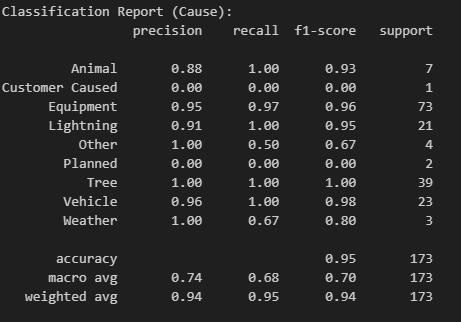

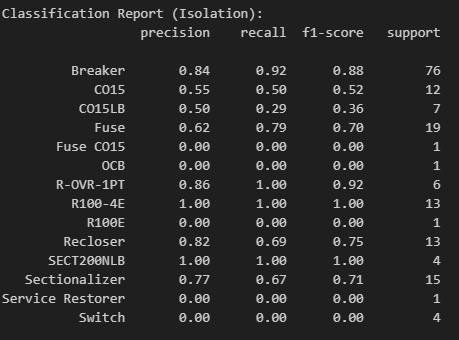

#### Results

In [36]:
# Print results for both models
print("\nBiLSTM with GloVe - K-Fold Cross Validation Results:")
print("Cause Classification:")
print(f"Average Accuracy: {np.mean(fold_accuracies_cause):.4f}")
print(f"Standard Deviation: {np.std(fold_accuracies_cause):.4f}")
print("\nIsolation Classification:")
print(f"Average Accuracy: {np.mean(fold_accuracies_isolation):.4f}")
print(f"Standard Deviation: {np.std(fold_accuracies_isolation):.4f}")

print("\nBiLSTM without GloVe - K-Fold Cross Validation Results:")
print("Cause Classification:")
print(f"Average Accuracy: {np.mean(fold_accuracies_cause_wo_glove):.4f}")
print(f"Standard Deviation: {np.std(fold_accuracies_cause_wo_glove):.4f}")
print("\nIsolation Classification:")
print(f"Average Accuracy: {np.mean(fold_accuracies_isolation_wo_glove):.4f}")
print(f"Standard Deviation: {np.std(fold_accuracies_isolation_wo_glove):.4f}")

# Print unique classes
print("\nUnique Classes (Cause):")
print(label_encoder_cause.classes_)
print("\nUnique Classes (Isolation):")
print(label_encoder_isolation.classes_)

# Example predictions

result_causeg, result_isolationg = predict_cause_and_isolation_bilstm_wglove("Lightning strike reported; power restored after circuit reset at Site0004.", model)
print(f"Predicted Cause: {result_causeg}")
print(f"Predicted Isolation Equipment Code: {result_isolationg}")

result_cause, result_isolation = predict_cause_and_isolation_bilstm_woglove("Lightning strike reported; power restored after circuit reset at Site0004.", model_wo_glove)
print(f"Predicted Cause: {result_cause}")
print(f"Predicted Isolation Equipment Code: {result_isolation}")


BiLSTM with GloVe - K-Fold Cross Validation Results:
Cause Classification:
Average Accuracy: 0.9322
Standard Deviation: 0.0344

Isolation Classification:
Average Accuracy: 0.7294
Standard Deviation: 0.1191

BiLSTM without GloVe - K-Fold Cross Validation Results:
Cause Classification:
Average Accuracy: 0.9043
Standard Deviation: 0.0236

Isolation Classification:
Average Accuracy: 0.7519
Standard Deviation: 0.1024

Unique Classes (Cause):
['Animal' 'Customer' 'Equipment' 'Lightning' 'Other' 'Planned' 'Tree'
 'Vehicle' 'Weather']

Unique Classes (Isolation):
['Breaker' 'CO15' 'CO15LB' 'Customer' 'Fuse' 'Fuse CO15' 'OCB' 'R-OVR-1PT'
 'R100-4E' 'R100E' 'Recloser' 'SECT200NLB' 'Sectionalizer'
 'Service Restorer' 'Switch']
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Predicted Cause: Lightning
Predicted Isolation Equipment Code: Breaker
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
Predicted Cause: Lightning
Predicted Isolation Equipment Code: Recloser


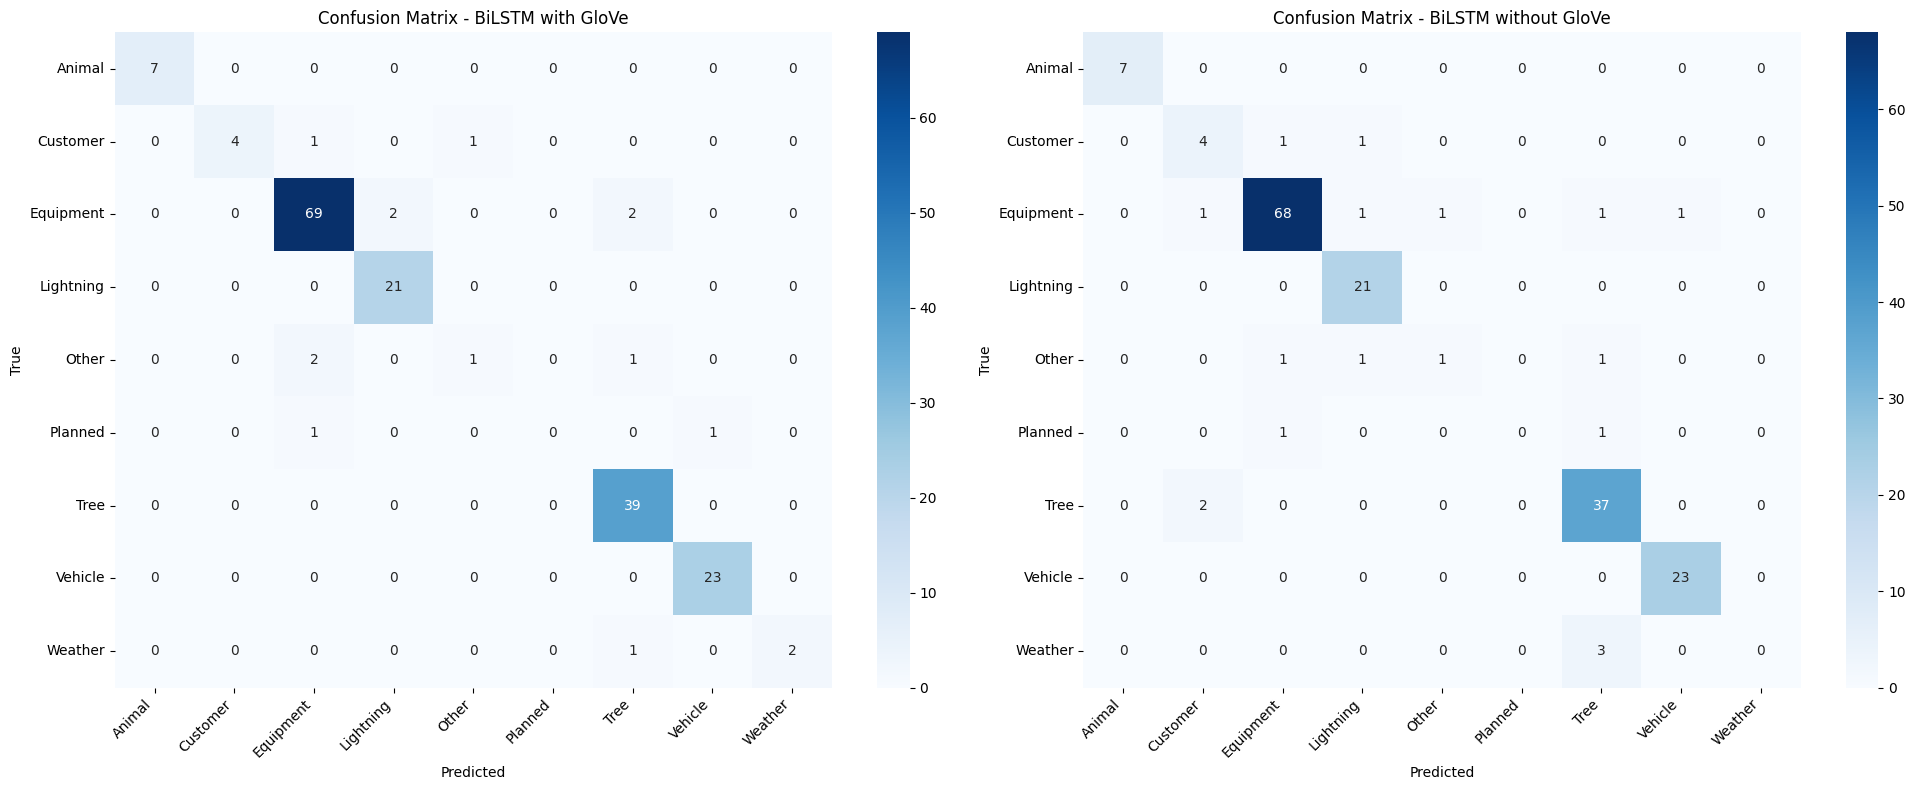

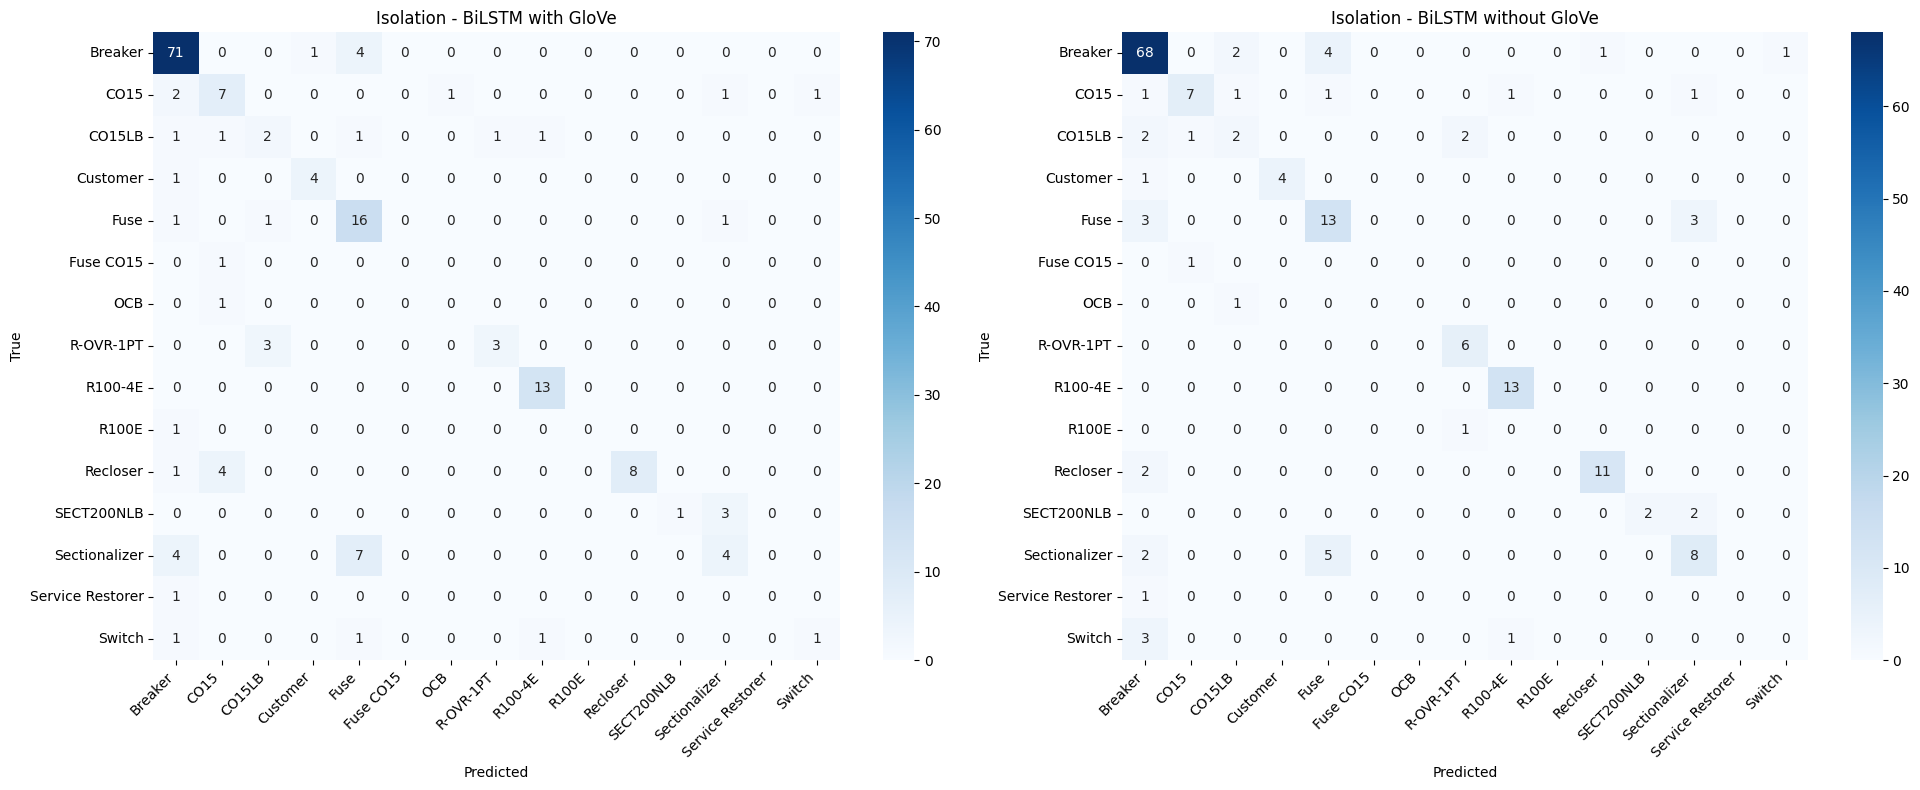

In [45]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Create figure with subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

# BiLSTM with GloVe confusion matrix
cm_glove_cause = confusion_matrix(all_true_labels_cause, all_predictions_cause)
sns.heatmap(cm_glove_cause, 
            annot=True, 
            fmt='d', 
            cmap='Blues',
            xticklabels=label_encoder_cause.classes_,
            yticklabels=label_encoder_cause.classes_,
            ax=ax1)
ax1.set_title('Confusion Matrix - BiLSTM with GloVe')
ax1.set_xlabel('Predicted')
ax1.set_ylabel('True')
plt.setp(ax1.get_xticklabels(), rotation=45, ha='right')

# BiLSTM without GloVe confusion matrix
cm_wo_glove_cause = confusion_matrix(all_true_labels_cause_wo_glove, all_predictions_cause_wo_glove)
sns.heatmap(cm_wo_glove_cause, 
            annot=True, 
            fmt='d', 
            cmap='Blues',
            xticklabels=label_encoder_cause.classes_,
            yticklabels=label_encoder_cause.classes_,
            ax=ax2)
ax2.set_title('Confusion Matrix - BiLSTM without GloVe')
ax2.set_xlabel('Predicted')
ax2.set_ylabel('True')
plt.setp(ax2.get_xticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.show()

# Same for Isolation Equipment
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

# BiLSTM with GloVe confusion matrix
cm_glove_iso = confusion_matrix(all_true_labels_isolation, all_predictions_isolation)
sns.heatmap(cm_glove_iso, 
            annot=True, 
            fmt='d', 
            cmap='Blues',
            xticklabels=label_encoder_isolation.classes_,
            yticklabels=label_encoder_isolation.classes_,
            ax=ax1)
ax1.set_title('Isolation - BiLSTM with GloVe')
ax1.set_xlabel('Predicted')
ax1.set_ylabel('True')
plt.setp(ax1.get_xticklabels(), rotation=45, ha='right')

# BiLSTM without GloVe confusion matrix
cm_wo_glove_iso = confusion_matrix(all_true_labels_isolation_wo_glove, all_predictions_isolation_wo_glove)
sns.heatmap(cm_wo_glove_iso, 
            annot=True, 
            fmt='d', 
            cmap='Blues',
            xticklabels=label_encoder_isolation.classes_,
            yticklabels=label_encoder_isolation.classes_,
            ax=ax2)
ax2.set_title('Isolation - BiLSTM without GloVe')
ax2.set_xlabel('Predicted')
ax2.set_ylabel('True')
plt.setp(ax2.get_xticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.show()

# Simple ML Models

In [37]:
import re
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.base import clone

# Constants
N_SPLITS = 5

class TextClassifier:
    def __init__(self):
        self.label_encoder_cause = LabelEncoder()
        self.label_encoder_isolation = LabelEncoder()
        self.vectorizer = None
        self.traditional_models = {}

    def preprocess_data(self, df):
        # Make a copy to avoid modifying original
        df = df.copy()

        # Replace unknown values
        df['Cause'] = df['Cause'].replace(['Unknown', 'Undetermined'], np.nan)
        df['Isolation Equipment Code'] = df['Isolation Equipment Code'].replace(['Unknown', 'Undetermined'], np.nan)

        # Drop rows with NaN in required columns
        df = df.dropna(subset=['Cause', 'Isolation Equipment Code', 'Details'])

        # Clean text
        df['Details'] = df['Details'].astype(str).apply(self.clean_text)

        # Remove empty strings after cleaning
        df = df[df['Details'] != '']

        return df

    @staticmethod
    def clean_text(text):
        # Handle NaN/float values
        if pd.isna(text):
            return ''
        # Convert to string if needed
        text = str(text)
        text = text.lower()
        text = re.sub(r'[^\w\s]', '', text)
        return text

    def prepare_labels(self, df):
        # Prepare labels
        y_cause = self.label_encoder_cause.fit_transform(df['Cause'])
        y_isolation = self.label_encoder_isolation.fit_transform(df['Isolation Equipment Code'])
        return y_cause, y_isolation

    def train_traditional_models(self, X_text, y_cause, y_isolation):
        # Initialize vectorizer
        self.vectorizer = TfidfVectorizer(max_features=5000)
        X_vectorized = self.vectorizer.fit_transform(X_text)

        # Initialize models
        model_dict = {
            'Naive Bayes': MultinomialNB(),
            'Decision Tree': DecisionTreeClassifier(random_state=42),
            'Random Forest': RandomForestClassifier(random_state=42),
            'Radial Basis SVM': SVC(kernel='rbf', random_state=42),
            'Neural Network': MLPClassifier(random_state=42),
            'K-Nearest Neighbors': KNeighborsClassifier(),
            'Logistic Regression': LogisticRegression(random_state=42),
            'Gradient Boosting': GradientBoostingClassifier(random_state=42)
        }

        self.traditional_models = {name: {'cause': None, 'isolation': None} for name in model_dict}
        results = {name: {'cause': [], 'isolation': []} for name in model_dict}

        kf = KFold(n_splits=N_SPLITS, shuffle=True, random_state=42)

        for fold, (train_idx, val_idx) in enumerate(kf.split(X_vectorized), 1):
            print(f"\nFold {fold}/{N_SPLITS}")
            X_train, X_val = X_vectorized[train_idx], X_vectorized[val_idx]
            y_cause_train, y_cause_val = y_cause[train_idx], y_cause[val_idx]
            y_iso_train, y_iso_val = y_isolation[train_idx], y_isolation[val_idx]

            best_scores = {name: {'cause': 0, 'isolation': 0} for name in model_dict}
            best_models = {name: {'cause': None, 'isolation': None} for name in model_dict}

            for name, base_model in model_dict.items():
                # Train and evaluate cause prediction
                model_cause = clone(base_model)
                model_cause.fit(X_train, y_cause_train)
                cause_acc = model_cause.score(X_val, y_cause_val)

                # Train and evaluate isolation prediction
                model_iso = clone(base_model)
                model_iso.fit(X_train, y_iso_train)
                iso_acc = model_iso.score(X_val, y_iso_val)

                # Store results
                results[name]['cause'].append(cause_acc)
                results[name]['isolation'].append(iso_acc)

                # Update best models if better performance
                if cause_acc > best_scores[name]['cause']:
                    best_scores[name]['cause'] = cause_acc
                    best_models[name]['cause'] = model_cause
                if iso_acc > best_scores[name]['isolation']:
                    best_scores[name]['isolation'] = iso_acc
                    best_models[name]['isolation'] = model_iso

            # Save best models
            for name in model_dict:
                self.traditional_models[name] = best_models[name]

        return results

    def predict_traditional(self, text, model_name):
        if model_name not in self.traditional_models:
            raise ValueError(f"Model {model_name} not found")

        # Vectorize input text
        text_vectorized = self.vectorizer.transform([text])

        # Get predictions
        cause_pred = self.traditional_models[model_name]['cause'].predict(text_vectorized)[0]
        iso_pred = self.traditional_models[model_name]['isolation'].predict(text_vectorized)[0]

        # Convert predictions to labels
        cause = self.label_encoder_cause.inverse_transform([cause_pred])[0]
        isolation = self.label_encoder_isolation.inverse_transform([iso_pred])[0]

        return cause, isolation

# Usage
classifier = TextClassifier()
df = pd.read_csv('PQEvents_Ticket_csv.csv')
df = classifier.preprocess_data(df)

# Prepare data
y_cause, y_isolation = classifier.prepare_labels(df)

# Train traditional models
results_traditional = classifier.train_traditional_models(
    df['Details'].tolist(),
    y_cause,
    y_isolation
)

# Print results
print("\n=== Traditional Models Performance ===")
print(f"{'Model Type':<20} {'Cause Accuracy':>15} {'Isolation Accuracy':>20}")
print("-" * 55)

for model_name, scores in results_traditional.items():
    cause_acc = np.mean(scores['cause'])
    cause_std = np.std(scores['cause'])
    iso_acc = np.mean(scores['isolation'])
    iso_std = np.std(scores['isolation'])
    print(f"{model_name:<20} {cause_acc:>15.4f} ± {cause_std:.4f} {iso_acc:>15.4f} ± {iso_std:.4f}")





Fold 1/5


C:\Users\rmathew2020\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\rmathew2020\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(



Fold 2/5


C:\Users\rmathew2020\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\rmathew2020\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(



Fold 3/5


C:\Users\rmathew2020\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\rmathew2020\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(



Fold 4/5


C:\Users\rmathew2020\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\rmathew2020\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(



Fold 5/5


C:\Users\rmathew2020\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\rmathew2020\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(



=== Traditional Models Performance ===
Model Type            Cause Accuracy   Isolation Accuracy
-------------------------------------------------------
Naive Bayes                   0.8202 ± 0.0488          0.6002 ± 0.1216
Decision Tree                 0.9360 ± 0.0627          0.8027 ± 0.0784
Random Forest                 0.9361 ± 0.0471          0.7970 ± 0.0870
Radial Basis SVM              0.8958 ± 0.0350          0.7968 ± 0.1015
Neural Network                0.9360 ± 0.0573          0.8027 ± 0.0821
K-Nearest Neighbors           0.8782 ± 0.0442          0.6526 ± 0.1120
Logistic Regression           0.8839 ± 0.0424          0.6987 ± 0.1103
Gradient Boosting             0.9361 ± 0.0565          0.8030 ± 0.0601


In [38]:
# Example predictions
text = "Vehicle hit pole causing power outage"
for model_name in classifier.traditional_models:
    cause, isolation = classifier.predict_traditional(text, model_name)
    print(f"\n{model_name} Predictions:")
    print(f"Cause: {cause}")
    print(f"Isolation Equipment: {isolation}")


Naive Bayes Predictions:
Cause: Vehicle
Isolation Equipment: Breaker

Decision Tree Predictions:
Cause: Vehicle
Isolation Equipment: SECT200NLB

Random Forest Predictions:
Cause: Vehicle
Isolation Equipment: SECT200NLB

Radial Basis SVM Predictions:
Cause: Equipment
Isolation Equipment: Breaker

Neural Network Predictions:
Cause: Vehicle
Isolation Equipment: Breaker

K-Nearest Neighbors Predictions:
Cause: Vehicle
Isolation Equipment: SECT200NLB

Logistic Regression Predictions:
Cause: Vehicle
Isolation Equipment: Breaker

Gradient Boosting Predictions:
Cause: Vehicle
Isolation Equipment: Breaker


In [39]:

# Example predictions
text = "Lightning strike reported; power restored after circuit reset at Site0004."
for model_name in classifier.traditional_models:
    cause, isolation = classifier.predict_traditional(text, model_name)
    print(f"\n{model_name} Predictions:")
    print(f"Cause: {cause}")
    print(f"Isolation Equipment: {isolation}")


Naive Bayes Predictions:
Cause: Equipment
Isolation Equipment: Breaker

Decision Tree Predictions:
Cause: Lightning
Isolation Equipment: Breaker

Random Forest Predictions:
Cause: Equipment
Isolation Equipment: Breaker

Radial Basis SVM Predictions:
Cause: Equipment
Isolation Equipment: Breaker

Neural Network Predictions:
Cause: Lightning
Isolation Equipment: Breaker

K-Nearest Neighbors Predictions:
Cause: Lightning
Isolation Equipment: Recloser

Logistic Regression Predictions:
Cause: Equipment
Isolation Equipment: Breaker

Gradient Boosting Predictions:
Cause: Lightning
Isolation Equipment: Recloser


#### Graphs

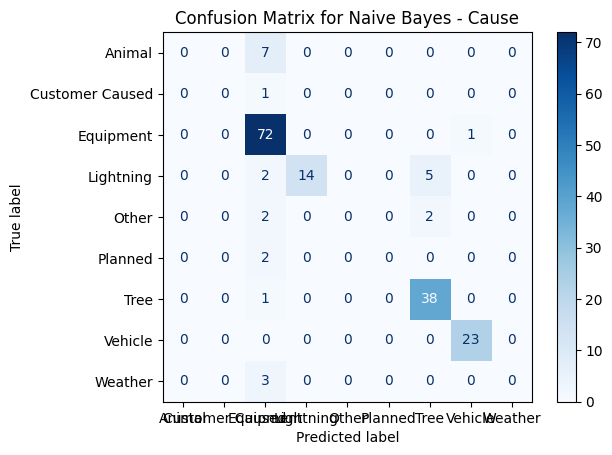

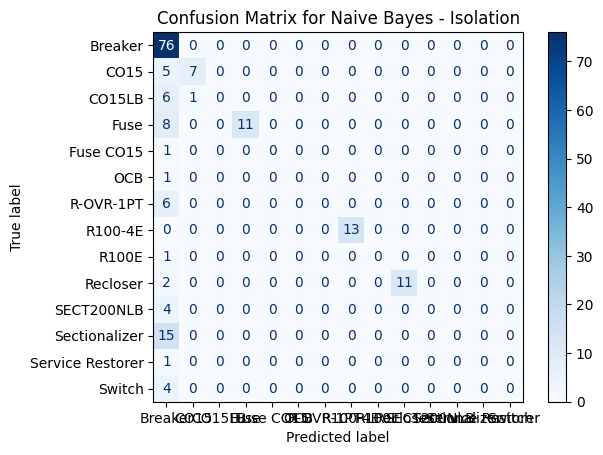

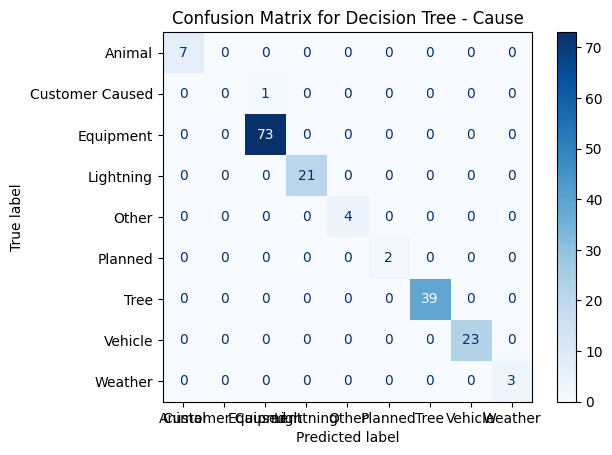

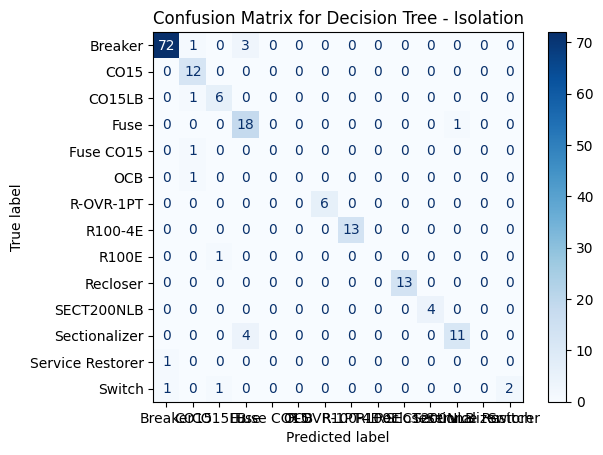

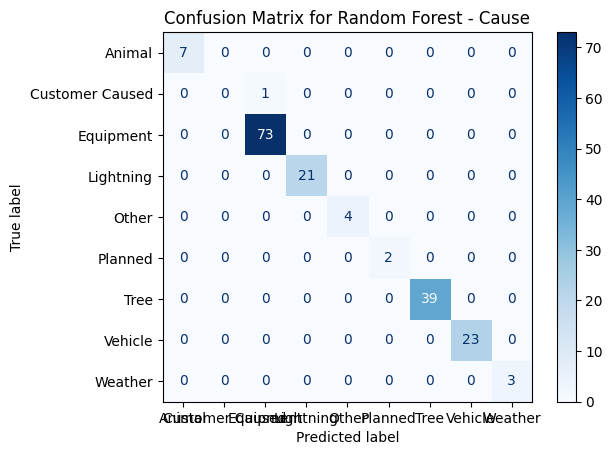

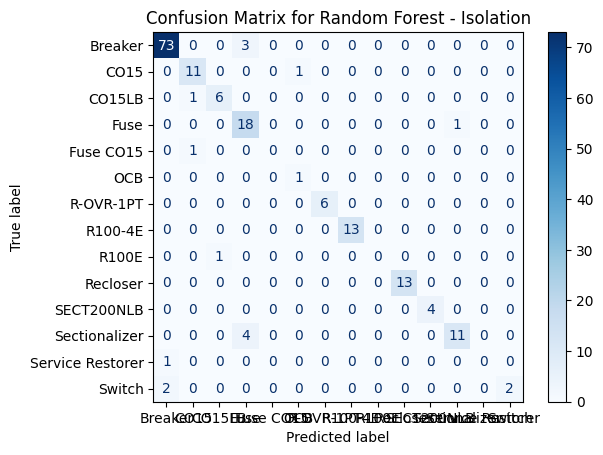

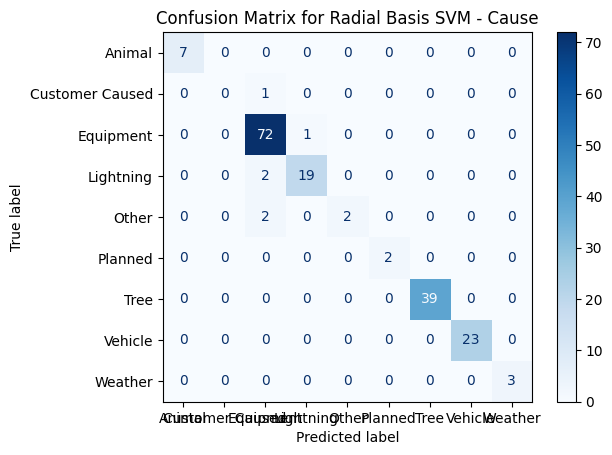

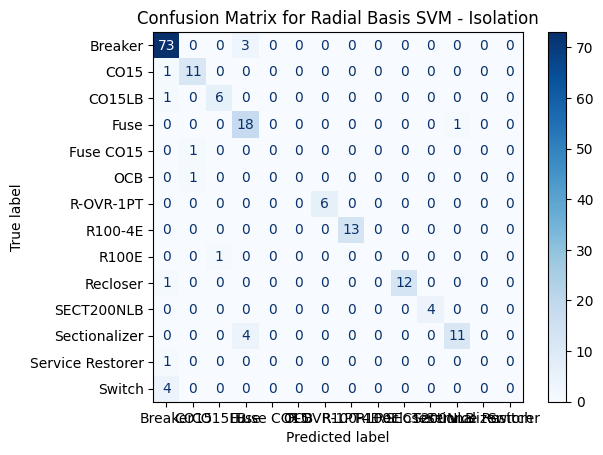

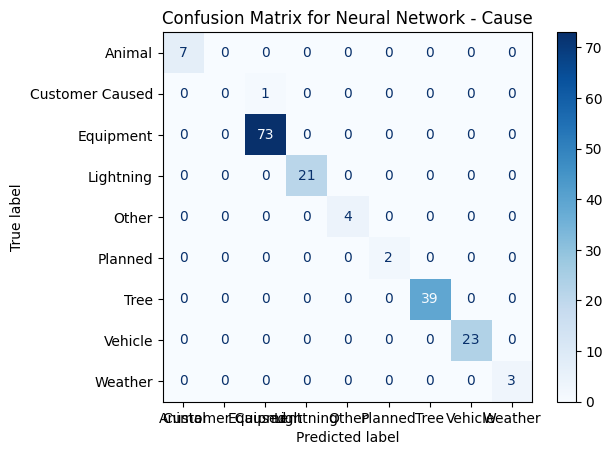

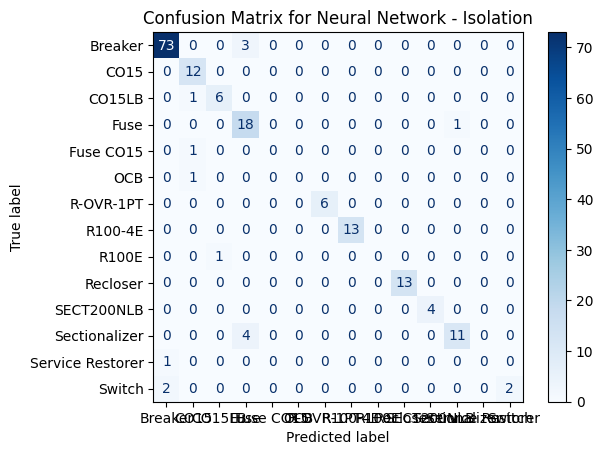

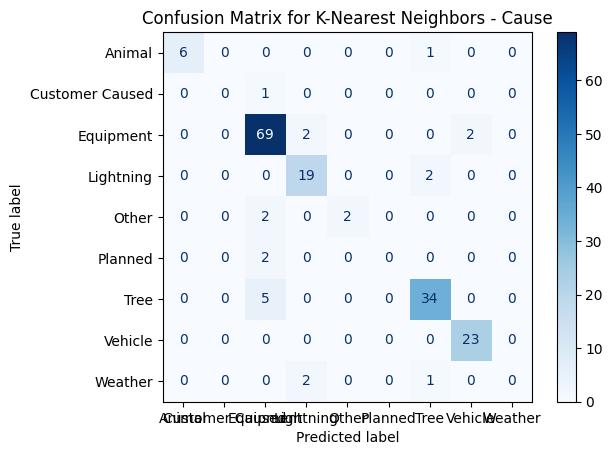

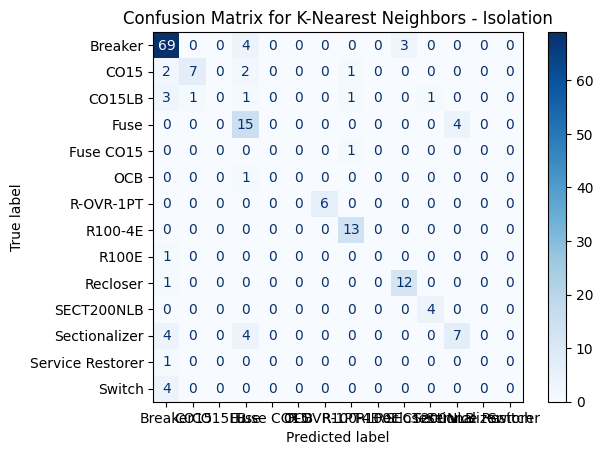

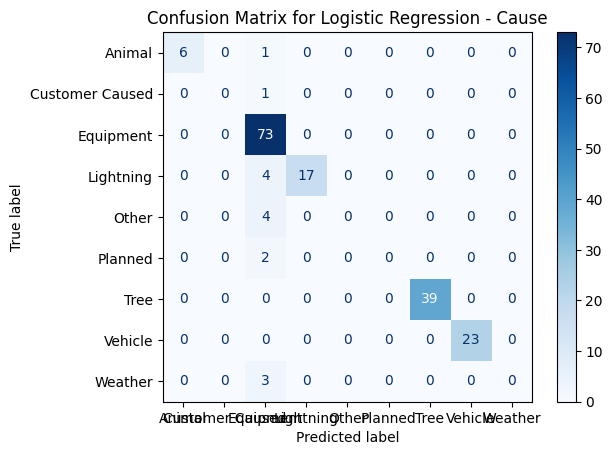

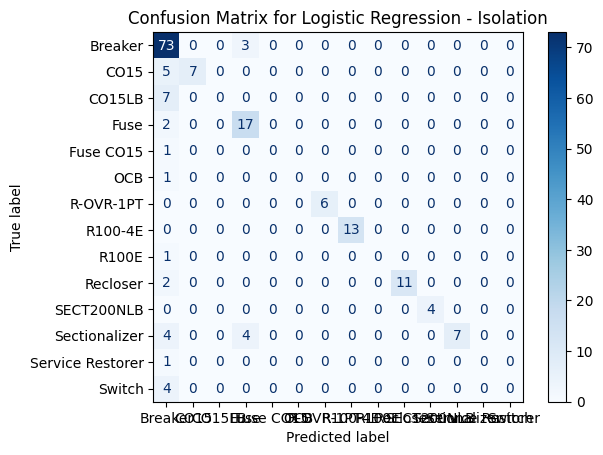

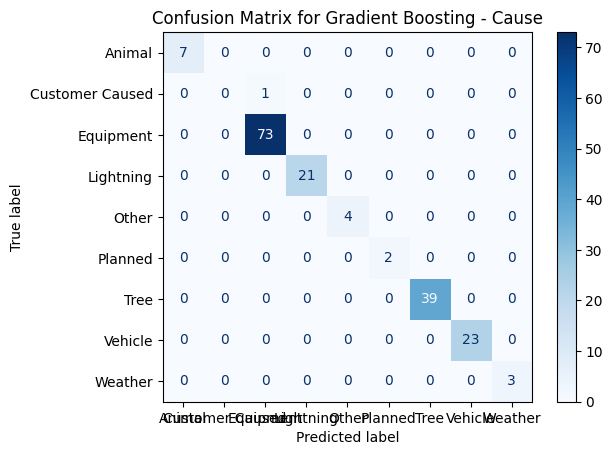

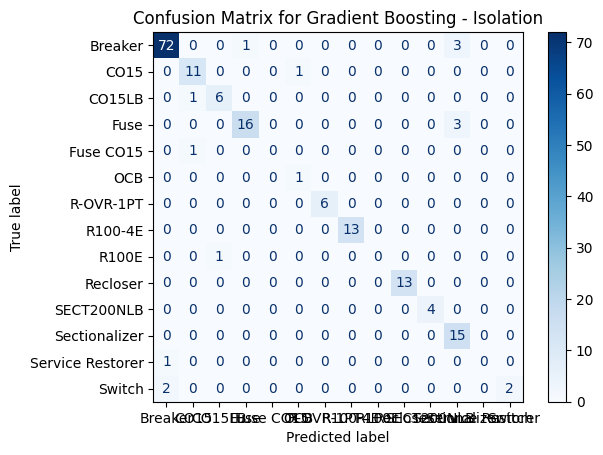

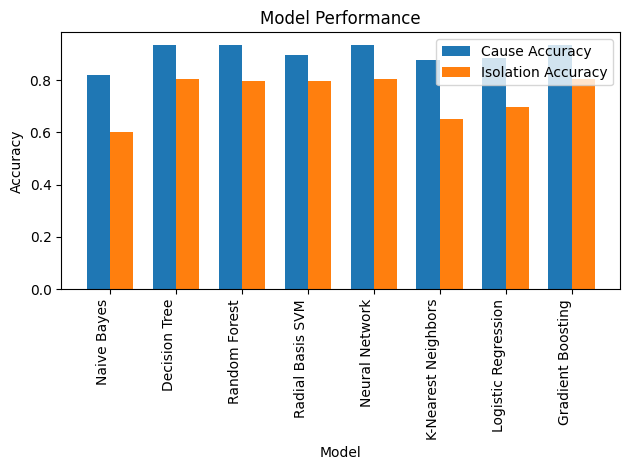

In [40]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Function to plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, classes, model_name):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f"Confusion Matrix for {model_name}")
    plt.show()

# Function to plot bar chart for model performance
def plot_model_performance(results_traditional):
    model_names = list(results_traditional.keys())
    cause_accuracies = [np.mean(results_traditional[model]['cause']) for model in model_names]
    isolation_accuracies = [np.mean(results_traditional[model]['isolation']) for model in model_names]
    
    x = np.arange(len(model_names))
    width = 0.35
    
    fig, ax = plt.subplots()
    rects1 = ax.bar(x - width/2, cause_accuracies, width, label='Cause Accuracy')
    rects2 = ax.bar(x + width/2, isolation_accuracies, width, label='Isolation Accuracy')
    
    ax.set_xlabel('Model')
    ax.set_ylabel('Accuracy')
    ax.set_title('Model Performance')
    ax.set_xticks(x)
    ax.set_xticklabels(model_names, rotation=90, ha='right')  # Rotate labels vertically
    ax.legend()
    
    fig.tight_layout()
    plt.show()

# Example usage
# Assuming you have y_true and y_pred for each model
for model_name in classifier.traditional_models:
    # Generate predictions for the entire dataset
    y_cause_pred = classifier.traditional_models[model_name]['cause'].predict(classifier.vectorizer.transform(df['Details'].tolist()))
    y_iso_pred = classifier.traditional_models[model_name]['isolation'].predict(classifier.vectorizer.transform(df['Details'].tolist()))
    
    # Plot confusion matrix for cause
    plot_confusion_matrix(y_cause, y_cause_pred, classifier.label_encoder_cause.classes_, f"{model_name} - Cause")
    
    # Plot confusion matrix for isolation
    plot_confusion_matrix(y_isolation, y_iso_pred, classifier.label_encoder_isolation.classes_, f"{model_name} - Isolation")

# Plot model performance
plot_model_performance(results_traditional)

# Overall Analysis

In [44]:
import pandas as pd

# Traditional models performance data
traditional_data = {
    'Model Type': [
        'Naive Bayes', 'Decision Tree', 'Random Forest', 'Radial Basis SVM',
        'Neural Network', 'K-Nearest Neighbors', 'Logistic Regression', 'Gradient Boosting'
    ],
    'Cause Accuracy': [
        0.8202, 0.9360, 0.9361, 0.8958,
        0.9360, 0.8782, 0.8839, 0.9361
    ],
    'Isolation Accuracy': [
        0.6002, 0.8027, 0.7970, 0.7968,
        0.8027, 0.6526, 0.6987, 0.8030
    ]
}

# BiLSTM with GloVe performance data
bilstm_glove_data = {
    'Model Type': ['BiLSTM with GloVe'],
    'Cause Accuracy': [0.9534],
    'Isolation Accuracy': [0.7793]
}

# BiLSTM without GloVe performance data
bilstm_wo_glove_data = {
    'Model Type': ['BiLSTM without GloVe'],
    'Cause Accuracy': [0.9043],
    'Isolation Accuracy': [0.7519]
}

# BERT performance data
bert_data = {
    'Model Type': ['BERT'],
    'Cause Accuracy': [0.6841],
    'Isolation Accuracy': [None]  # N/A for isolation accuracy
}

# Combine all data into a single DataFrame
df_traditional = pd.DataFrame(traditional_data)
df_bilstm_glove = pd.DataFrame(bilstm_glove_data)
df_bilstm_wo_glove = pd.DataFrame(bilstm_wo_glove_data)
df_bert = pd.DataFrame(bert_data)

df_combined = pd.concat([df_traditional, df_bilstm_glove, df_bilstm_wo_glove, df_bert], ignore_index=True)

# Sort by Cause Accuracy and then by Isolation Accuracy in descending order
df_combined = df_combined.sort_values(by=['Cause Accuracy', 'Isolation Accuracy'], ascending=[False, False])

# Display the combined DataFrame
print("\nModel Performance Comparison (Sorted by Cause Accuracy):")
print("-" * 70)
print(df_combined.to_string(index=False, float_format=lambda x: f"{x:.4f}" if pd.notnull(x) else "N/A"))



Model Performance Comparison (Sorted by Cause Accuracy):
----------------------------------------------------------------------
          Model Type  Cause Accuracy  Isolation Accuracy
   BiLSTM with GloVe          0.9534              0.7793
   Gradient Boosting          0.9361              0.8030
       Random Forest          0.9361              0.7970
       Decision Tree          0.9360              0.8027
      Neural Network          0.9360              0.8027
BiLSTM without GloVe          0.9043              0.7519
    Radial Basis SVM          0.8958              0.7968
 Logistic Regression          0.8839              0.6987
 K-Nearest Neighbors          0.8782              0.6526
         Naive Bayes          0.8202              0.6002
                BERT          0.6841                 NaN


C:\Users\rmathew2020\AppData\Local\Temp\ipykernel_20176\1186468977.py:46: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_combined = pd.concat([df_traditional, df_bilstm_glove, df_bilstm_wo_glove, df_bert], ignore_index=True)


Model performs very well on classes with more samples (ex: Equipment, Tree)
Struggles with underrepresented classes (Customer Caused, Planned: 2)


Unique Cause Classes with Counts:
----------------------------------------
Equipment               77
Tree                    49
Vehicle                 28
Lightning               24
Animal                  15
Customer                 6
Other                    4
Weather                  3
Planned                  2

Unique Isolation Equipment Classes with Counts:
----------------------------------------
Breaker                 76
Fuse                    19
Sectionalizer           15
Recloser                13
R100-4E                 13
CO15                    12
CO15LB                   9
R-OVR-1PT                6
Switch                   4
SECT200NLB               4
Unknown                  2
Service Restorer         1
Fuse CO15                1
OCB                      1
R100E                    1

Summary:
Total number of Cause classes: 9
Total number of Isolation Equipment classes: 15


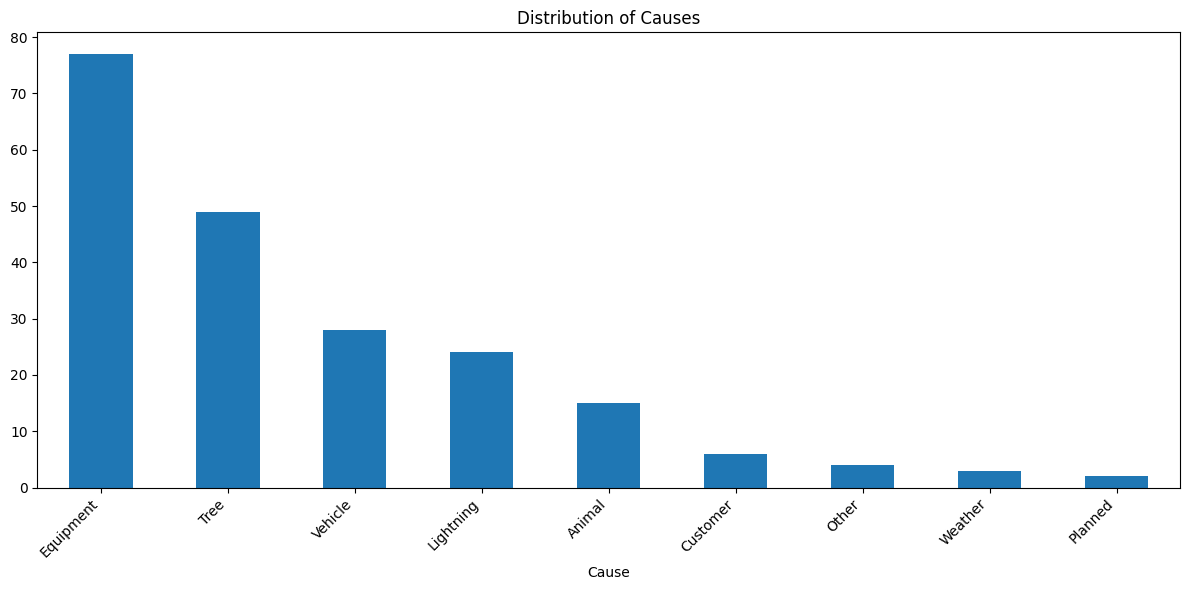

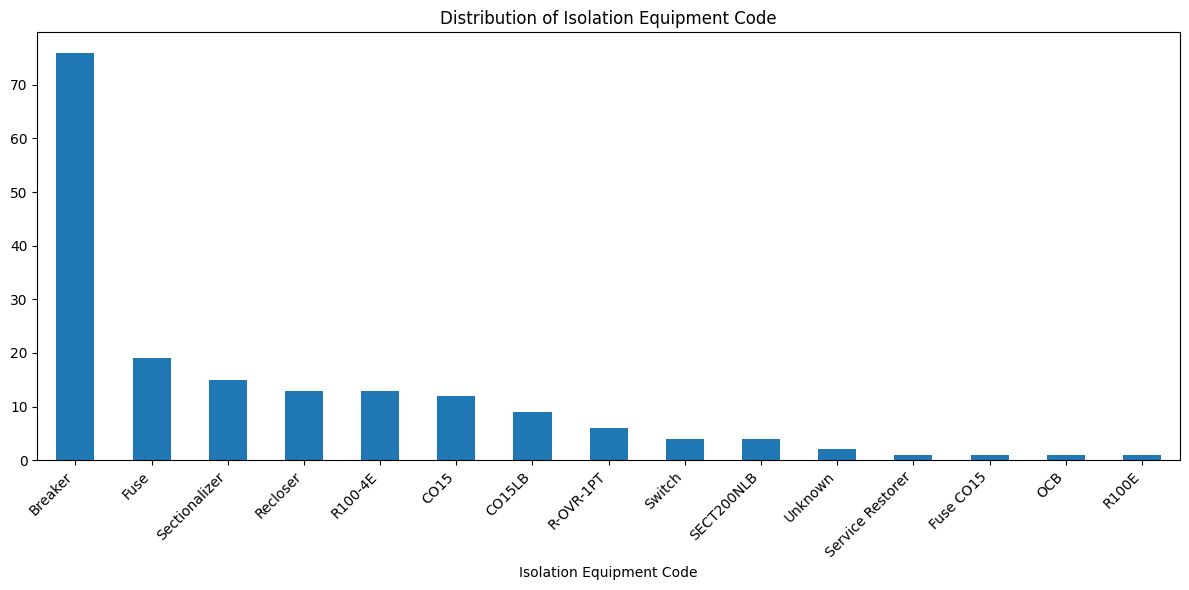

In [42]:
df = pd.read_csv('PQEvents_Ticket_csv.csv')

# Remove Unknown/Undetermined causes
df = df[~df['Cause'].isin(['Unknown', 'Undetermined'])]

# Combine Customer causes
df['Cause'] = df['Cause'].replace(['Customer Request', 'Customer Caused'], 'Customer')


# Print updated counts
print("\nUnique Cause Classes with Counts:")
print("-" * 40)
cause_unique = df['Cause'].value_counts()
for cause, count in cause_unique.items():
    print(f"{cause:<20} {count:>5}")


print("\nUnique Isolation Equipment Classes with Counts:")
print("-" * 40)
isolation_unique = df['Isolation Equipment Code'].value_counts()
for isolation, count in isolation_unique.items():
    print(f"{isolation:<20} {count:>5}")

# Print total counts
print("\nSummary:")
print(f"Total number of Cause classes: {len(cause_unique)}")
print(f"Total number of Isolation Equipment classes: {len(isolation_unique)}")

# Bar plot with updated causes
plt.figure(figsize=(12, 6))
cause_unique.plot(kind='bar')
plt.title('Distribution of Causes')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Bar plot with isolation_unique
plt.figure(figsize=(12, 6))
isolation_unique.plot(kind='bar')
plt.title('Distribution of Isolation Equipment Code')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()